In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [20]:
import os
os.chdir('C:\\0-ece204\\pr5')

In [2]:
full_data = pd.read_csv('Full Data.txt', index_col = [0])
full_data

,gender,ajcc_pathologic_tumor_stage,tumor_status,DSS,DSS.time,TP53,TTN,FAT1,MUC16,CSMD3,...,NIPBL,CEACAM5,CEACAM6,CLCA4,EGFR,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,age
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,0,0.0,0.279452,822.678,1157.3300,1620.71,1004.4700,1.2325,...,1595.440,56.0776,423.3550,502.2340,722.847,92,8,0,2,1
TCGA-BA-4074,1,0,1,1.0,1.265753,1805.510,103.6870,6415.45,17.3422,0.3854,...,1605.890,153.3820,275.9330,12.7176,1267.900,106,8,0,1,1
TCGA-BA-4075,1,1,1,1.0,0.775342,383.760,295.9180,4162.40,1.0720,36.9824,...,907.410,18.2232,45.5581,10.1836,4833.430,113,10,0,4,0
TCGA-BA-4077,0,0,1,1.0,3.106849,1929.260,207.3870,7246.87,432.6270,0.0000,...,1174.690,2392.6900,2437.9200,720.8850,2371.940,234,20,0,6,0
TCGA-BA-5149,1,0,1,1.0,2.208219,165.298,347.9540,8848.73,110.5410,0.3422,...,1798.770,37.3032,447.6390,5.4757,6934.280,96,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JO,0,0,1,1.0,1.728767,1604.880,176.1930,1881.36,347.7040,2.8008,...,854.256,1498.8500,2014.6000,82.8248,530.911,135,9,0,4,1
TCGA-UF-A7JS,1,0,1,1.0,1.863014,2457.400,1379.4300,1339.31,243.6470,19.4320,...,982.063,358.7440,294.4690,32.8849,246.637,50,1,0,1,1
TCGA-UF-A7JT,0,0,1,1.0,2.720548,1684.850,149.5190,3430.74,213.8530,14.2857,...,1009.520,49.7835,209.5240,200.4330,790.905,152,10,0,3,1


# Cox model + FDR

In [ ]:
def coxfitter(data, duration, event):
    # Define the CoxPHFitter object
    cph = CoxPHFitter()
    # Fit the model to your data
    cph.fit(data, duration_col= duration, event_col=event)
    summary = cph.summary
    return summary

In [54]:
def cox_model(df, time, lis):
    data = df[df['DSS.time'] <= time]
    signi = []
    pvals = []
    pvals_correct = []
    for i in lis:
        summary = coxfitter(data[[i ,'gender','ajcc_pathologic_tumor_stage', 
                                   'tumor_status', 'age', 'DSS.time', 'DSS']], 'DSS.time', 'DSS')
        p_values = summary["p"]
        rejected, pvals_corrected = multipletests(p_values, method='fdr_bh')[:2]
        summary['p_corrected'] = pvals_corrected
        p = summary.loc[i, "p"]
        p_correct = summary.loc[i, "p_corrected"]
        pvals.append(p)
        pvals_correct.append(p_correct)
        signi.append(rejected[0])
    features = [col for col in lis]  # list of features
    # Create a DataFrame with the results
    results = pd.DataFrame({'Features': features,'p': pvals,'p_corrected': pvals_correct, 'significant': signi})
    return results[results['significant'] == True]


In [55]:
# mutation
mutation = ['Missense_Mutation', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site']
cox_model(full_data, 2, mutation)# example: use full data and 2 years as limit

,Features,p,p_corrected,significant
0,Missense_Mutation,4.747304e-08,2.373652e-07,True
1,Nonsense_Mutation,3.141682e-04,1.570841e-03,True
2,Nonstop_Mutation,8.020092e-03,4.010046e-02,True
3,Splice_Site,3.520589e-05,1.760294e-04,True


In [6]:
# feature dic for mutation
time_limit = range(1,11)
feature_dic = {}
for i in time_limit:
    df = cox_model(full_data, i, mutation)
    feature_dic[i] = list(df['Features'])
feature_dic

{1: ['Missense_Mutation', 'Nonsense_Mutation'],
 2: ['Missense_Mutation',
  'Nonsense_Mutation',
  'Nonstop_Mutation',
  'Splice_Site'],
 3: ['Missense_Mutation',
  'Nonsense_Mutation',
  'Nonstop_Mutation',
  'Splice_Site'],
 4: ['Missense_Mutation',
  'Nonsense_Mutation',
  'Nonstop_Mutation',
  'Splice_Site'],
 5: ['Missense_Mutation',
  'Nonsense_Mutation',
  'Nonstop_Mutation',
  'Splice_Site'],
 6: ['Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site'],
 7: ['Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site'],
 8: ['Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site'],
 9: ['Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site'],
 10: ['Missense_Mutation', 'Nonsense_Mutation', 'Splice_Site']}

# Classification

In [26]:
#select top n mutations by z values as features columns from full_data

In [58]:
def classification_svm(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # SVM
   
    # Define the model
    svm_clf = svm.SVC(kernel='rbf')

    # Train the model
    svm_clf.fit(X_train, y_train)
   
    # Predict on the test set
    svm_predictions = svm_clf.predict(X_test)

    # Evaluate the model
    return confusion_matrix(y_test, svm_predictions), accuracy_score(y_test, svm_predictions)
    #print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

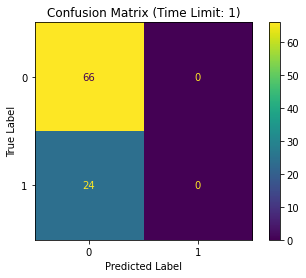

For time limit 1 and mutation features from Cox model
SVM Accuracy 0.7027777777777782


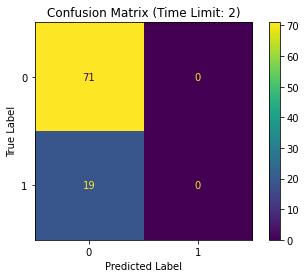

For time limit 2 and mutation features from Cox model
SVM Accuracy 0.703


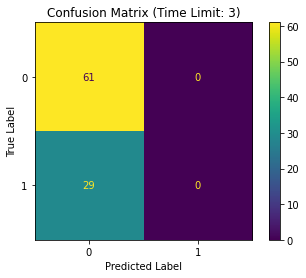

For time limit 3 and mutation features from Cox model
SVM Accuracy 0.7057777777777778


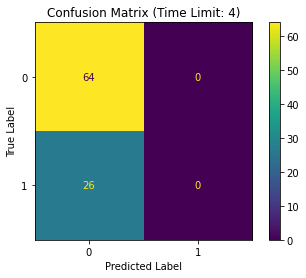

For time limit 4 and mutation features from Cox model
SVM Accuracy 0.705888888888889


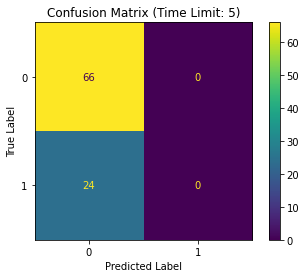

For time limit 5 and mutation features from Cox model
SVM Accuracy 0.708777777777778


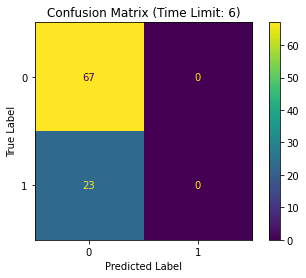

For time limit 6 and mutation features from Cox model
SVM Accuracy 0.6996666666666665


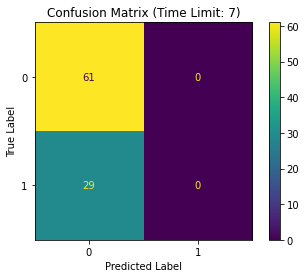

For time limit 7 and mutation features from Cox model
SVM Accuracy 0.7084444444444444


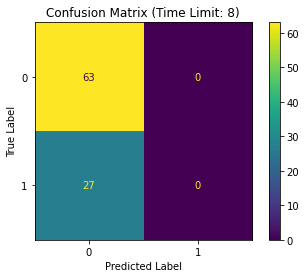

For time limit 8 and mutation features from Cox model
SVM Accuracy 0.7091111111111111


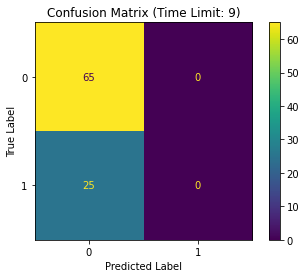

For time limit 9 and mutation features from Cox model
SVM Accuracy 0.7034444444444448


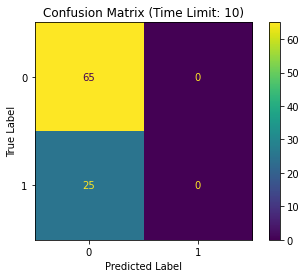

For time limit 10 and mutation features from Cox model
SVM Accuracy 0.7027777777777783


In [63]:
acc_svm = []
for i in time_limit:
    lis = []
    for k in range(100):
        matrix, accuracy = classification_svm(full_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_svm.append(mean_acc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Time Limit: {i})')
    plt.show()
    print('For time limit ' + str(i) + ' and mutation features from Cox model')
    print('SVM Accuracy ' + str(mean_acc))
    

In [64]:
def classification_logistic(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    log_reg = LogisticRegression()

    # Train the model
    log_reg.fit(X_train, y_train)
    log_reg_predictions = log_reg.predict(X_test)

    # Evaluate the model
    return confusion_matrix(y_test, log_reg_predictions), accuracy_score(y_test, log_reg_predictions)
    #print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_predictions))

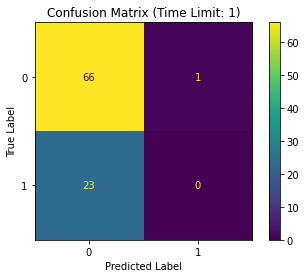

For time limit 1 and mutation features from Cox model
Logistic Regression Accuracy 0.7024444444444446


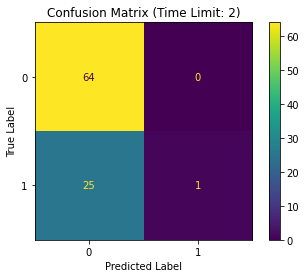

For time limit 2 and mutation features from Cox model
Logistic Regression Accuracy 0.7121111111111113


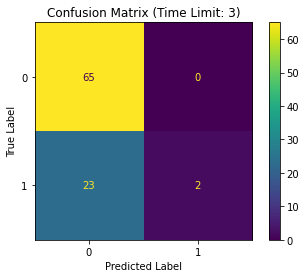

For time limit 3 and mutation features from Cox model
Logistic Regression Accuracy 0.7035555555555558


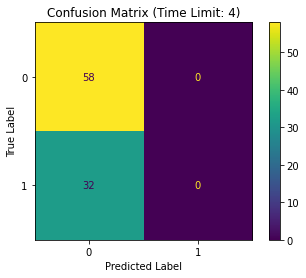

For time limit 4 and mutation features from Cox model
Logistic Regression Accuracy 0.7052222222222223


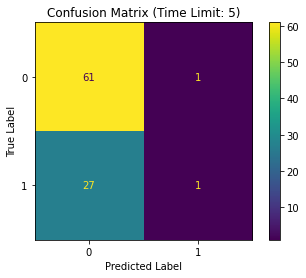

For time limit 5 and mutation features from Cox model
Logistic Regression Accuracy 0.7042222222222222


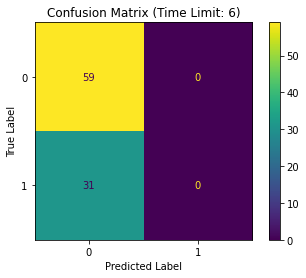

For time limit 6 and mutation features from Cox model
Logistic Regression Accuracy 0.7005555555555552


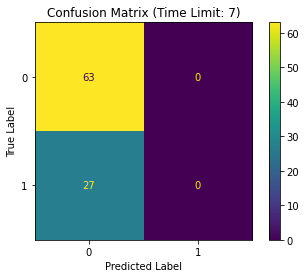

For time limit 7 and mutation features from Cox model
Logistic Regression Accuracy 0.701


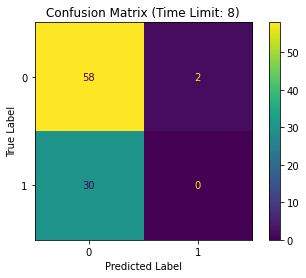

For time limit 8 and mutation features from Cox model
Logistic Regression Accuracy 0.7053333333333337


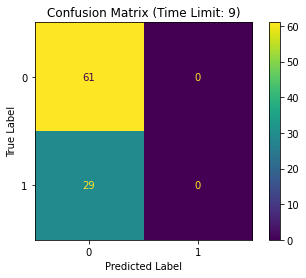

For time limit 9 and mutation features from Cox model
Logistic Regression Accuracy 0.7015555555555558


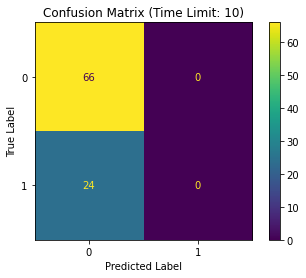

For time limit 10 and mutation features from Cox model
Logistic Regression Accuracy 0.6986666666666668


In [65]:
acc_logi = []
for i in time_limit:
    lis = []
    for k in range(100):
        matrix, accuracy = classification_logistic(full_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_logi.append(mean_acc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Time Limit: {i})')
    plt.show()
    print('For time limit ' + str(i) + ' and mutation features from Cox model')
    print('Logistic Regression Accuracy ' + str(mean_acc))

In [68]:
def classification_randomforest(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_clf = RandomForestClassifier()

    # Train the model
    rf_clf.fit(X_train, y_train)
    # Predict on the test set
    rf_predictions = rf_clf.predict(X_test)

    # Evaluate the model
    return confusion_matrix(y_test, rf_predictions), accuracy_score(y_test, rf_predictions)
    #print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

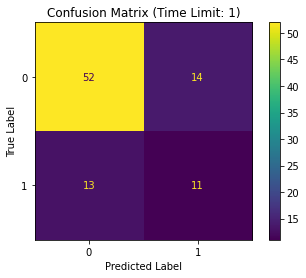

For time limit 1 and mutation features from Cox model
Random Forest Accuracy 0.7013333333333333


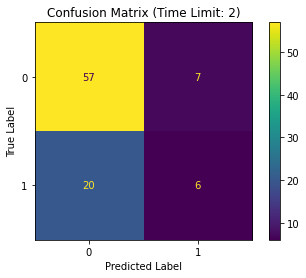

For time limit 2 and mutation features from Cox model
Random Forest Accuracy 0.7328888888888888


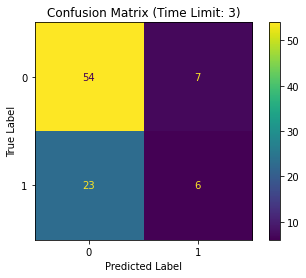

For time limit 3 and mutation features from Cox model
Random Forest Accuracy 0.7248888888888894


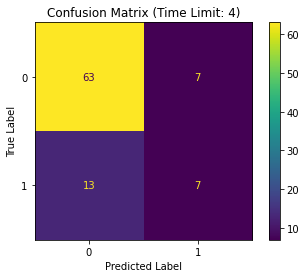

For time limit 4 and mutation features from Cox model
Random Forest Accuracy 0.7293333333333334


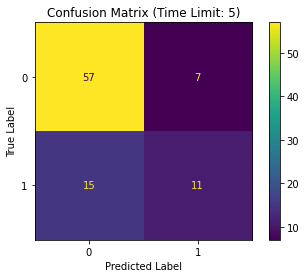

For time limit 5 and mutation features from Cox model
Random Forest Accuracy 0.7282222222222225


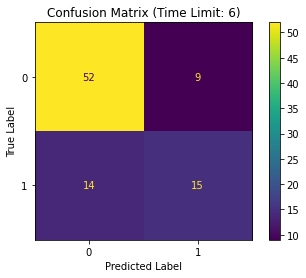

For time limit 6 and mutation features from Cox model
Random Forest Accuracy 0.7247777777777776


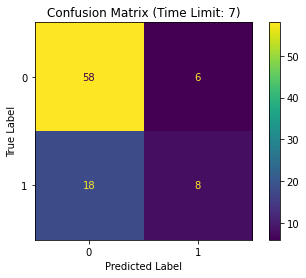

For time limit 7 and mutation features from Cox model
Random Forest Accuracy 0.7171111111111115


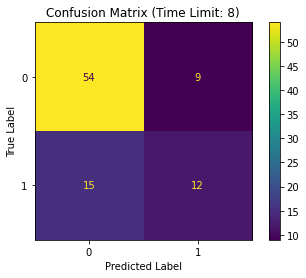

For time limit 8 and mutation features from Cox model
Random Forest Accuracy 0.7294444444444449


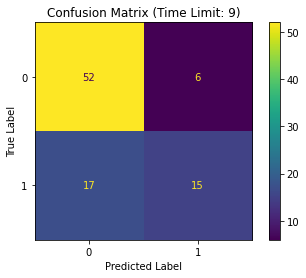

For time limit 9 and mutation features from Cox model
Random Forest Accuracy 0.7252222222222221


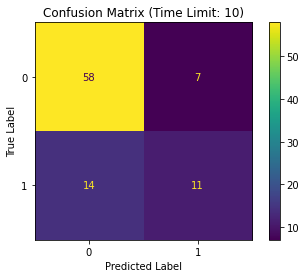

For time limit 10 and mutation features from Cox model
Random Forest Accuracy 0.7302222222222221


In [69]:
acc_random = []
for i in time_limit:
    lis = []
    for k in range(100):
        matrix, accuracy = classification_randomforest(full_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_random.append(mean_acc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Time Limit: {i})')
    plt.show()
    print('For time limit ' + str(i) + ' and mutation features from Cox model')
    print('Random Forest Accuracy ' + str(mean_acc))

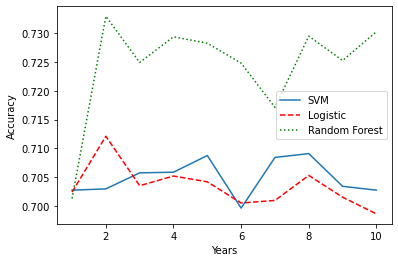

In [70]:
plt.plot(time_limit, acc_svm, label='SVM')  # Default color and line style
plt.plot(time_limit, acc_logi, 'r--', label='Logistic')  # Red dashed line
plt.plot(time_limit, acc_random, 'g:', label='Random Forest')  # Green dotted line

# Optional: add a legend to explain which line is which
plt.legend()
plt.xlabel('Years')
plt.ylabel('Accuracy')
# Show the plot
plt.show()

# Best parameters for Random Forest

In [14]:
def best_estimator(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_clf = RandomForestClassifier()
    param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
    # Train the model
    CV_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv = 5)
    CV_rf.fit(X_train, y_train)
    # Predict on the test set
    return CV_rf.best_params_

In [15]:
# get the best parameter for each time based on each feature
para_dic = {}
for i in time_limit:
    para_dic[i] = best_estimator(full_data, feature_dic[i])

In [18]:
def classification_randomforestcv(df, features, best_para):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_best = RandomForestClassifier(n_estimators= best_para['n_estimators'], max_features=best_para['max_features'], max_depth=best_para['max_depth'], criterion=best_para['criterion'])
    rf_best.fit(X_train, y_train)

    predictions = rf_best.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cv_score = cross_val_score(rf_best, X, y, cv=5)
    # Evaluate the model
    return accuracy, cv_score.mean()

In [21]:
acc_grid = []
acc_cv = []
for i in time_limit:
    lis_grid = []
    lis_cv = []
    for k in range(10):
        grid_accuracy, cv_score = classification_randomforestcv(full_data, feature_dic[i],para_dic[i])
        lis_grid.append(grid_accuracy)
        lis_cv.append(cv_score)
    mean_grid = sum(lis_grid)/len(lis_grid)
    mean_cv =  sum(lis_cv)/len(lis_cv)
    acc_grid.append(mean_grid)
    acc_cv.append(mean_cv)
    print('For time limit ' + str(i) + ' and mutation features from Cox model')
    print('Random Forest GridSearchCV Accuracy ' + str(mean_grid))
    print('Random Forest cross validation Accuracy ' + str(mean_cv))

For time limit 1 and mutation features from Cox model
Random Forest GridSearchCV Accuracy 0.6744444444444445
Random Forest cross validation Accuracy 0.6953333333333334
For time limit 2 and mutation features from Cox model
Random Forest GridSearchCV Accuracy 0.73
Random Forest cross validation Accuracy 0.695111111111111
For time limit 3 and mutation features from Cox model
Random Forest GridSearchCV Accuracy 0.7211111111111113
Random Forest cross validation Accuracy 0.6782222222222221
For time limit 4 and mutation features from Cox model
Random Forest GridSearchCV Accuracy 0.7033333333333334
Random Forest cross validation Accuracy 0.6975555555555556
For time limit 5 and mutation features from Cox model
Random Forest GridSearchCV Accuracy 0.7233333333333334
Random Forest cross validation Accuracy 0.6988888888888889
For time limit 6 and mutation features from Cox model
Random Forest GridSearchCV Accuracy 0.7000000000000001
Random Forest cross validation Accuracy 0.6777777777777778
For tim

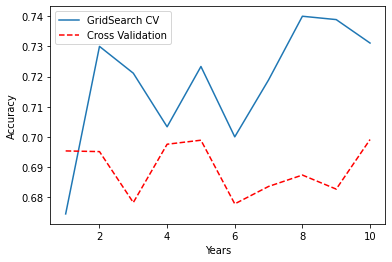

In [22]:
plt.plot(time_limit, acc_grid, label='GridSearch CV')  # Default color and line style
plt.plot(time_limit, acc_cv, 'r--', label='Cross Validation')  # Red dashed line

# Optional: add a legend to explain which line is which
plt.legend()
plt.xlabel('Years')
plt.ylabel('Accuracy')
# Show the plot
plt.show()